In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *

cupyon=True

try: 
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 150*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -20*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 20*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 10000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")

Tweezer starting positions: -20.0 microns or -2.267573696145124 MHz
Tweezer ending positions: 20.0 microns or 2.267573696145124 MHz
One micron corresponds to 0.1133786848072586 MHz


In [16]:

def constructamplitudes(amplitudes, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    amplitudes = tonumpy(amplitudes)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, amplitudes)
    
    return tocupy(constructed_values)

def constructphases(phases, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    phases = tonumpy(phases)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, phases)
    
    return tocupy(constructed_values)

def constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    constructedwaveform = cp.zeros(len(optimizationspace))
    for i in range(len(frequencies)):
        amplitudeprofile = constructamplitudes(amplitudes[i], optimizationspace)
        phaseprofile = constructphases(phases[i], optimizationspace)
        frequencyprofile = cp.linspace(frequencies[i], frequencies[i]*len(optimizationspace), len(optimizationspace))
        constructedwaveform += amplitudeprofile * np.cos(2*np.pi*frequencyprofile*optimizationspace + phaseprofile)
    
    return tocupy(constructedwaveform)

def init_opt_waveformfitFourierVariant(AWGinitguess,freqres, ampres, phaseres, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(0,len(AWGinitguess) / numpix_real,len(AWGinitguess))[numpix_frame:-numpix_frame]
    
    startfrequency = positionstofourier(startlocation, 0, globalvariables)[0] - numpix_real // 2
    endfrequency = positionstofourier(endlocation, 0, globalvariables)[0] - numpix_real // 2
    
    frequencies = cp.linspace(startfrequency, endfrequency, freqres) # in units of pixels
    amplitudes = cp.random.rand(freqres, ampres) # arbitrary units
    phases = cp.zeros((freqres, phaseres)) # in units of pixels
    
    
    constructedwaveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables )
    
    
    def objective(params):
        num_frequencies = len(frequencies)
        num_amplitudes = ampres
        num_phases = phaseres
        
        amplitudes = tocupy(params[:num_frequencies * num_amplitudes].reshape((num_frequencies, num_amplitudes)))
        phases = tocupy(params[num_frequencies * num_amplitudes:].reshape((num_frequencies, num_phases)))
        
        reconstructed_waveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables)
        error = cp.sum((reconstructed_waveform - optimizationsection)**2)
        print(error)
        return tonumpy(error)
    
    initial_guess = cp.concatenate([amplitudes.flatten(), phases.flatten()])
    # result = minimize(objective, tonumpy(initial_guess), method='L-BFGS-B')
    # First step: Differential Evolution    
    # Second step: Local Gradient Descent
    result_gd = minimize(objective, initial_guess.get(), method='L-BFGS-B')

    optimized_params = result_gd.x
    opt_amplitudes = optimized_params[:freqres * ampres].reshape((freqres, ampres))
    opt_phases = optimized_params[freqres * ampres:].reshape((freqres, phaseres))
    
    optimizedwaveform = constructFourierVariant(optimizationspace, frequencies, opt_amplitudes, opt_phases, globalvariables)
    
    AWGwaveform[numpix_frame:-numpix_frame] = optimizedwaveform
    parameters = [frequencies, opt_amplitudes, opt_phases]
    return AWGwaveform, parameters



def opt_atomsurvival_PhaseOnly(AWGinitguess, polydegree, inittemperature, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = AWGinitguess.copy()
    AWGwaveform_expresponse = exponentialphaseresponse(AWGinitguess)
    AWGwaveform_expresponse_template = AWGwaveform_expresponse.copy()

    optimizationsection = AWGwaveform_expresponse[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(-0.5,0.5,len(optimizationsection))
    
    initial_distributions = initdistribution_MaxwellBoltzmann(num_particles, inittemperature, 1e-8, atommass, globalvariables)
    shotlast = realtofourier(zeropadframe(AWGwaveform_expresponse[-numpix_frame:], globalvariables))
    gaussianwidth = get_gaussianwidth_1d(tonumpy(zoomin((shotlast), 2)))
    plt.plot(tonumpy((shotlast)))
    plt.show()
    print(gaussianwidth)
    endtweezerlocation = get_gaussiancenter_1d((shotlast))
    print(endtweezerlocation)
    print(len(initial_distributions[0]))
    
    def objective_survivalPhaseOnly(params):
        legendre_poly = Legendre(params)
        reconstructed_phases = legendre_poly(tonumpy(optimizationspace))
        AWGwaveform_expresponse_template[numpix_frame:-numpix_frame] *= cp.exp(tocupy(reconstructed_phases) *1j)
        print("waveform made")
        forces = retrieveforces(AWGwaveform_expresponse_template, globalvariables, 10, True)
        print("forces made")
        xout, vout, accel = montecarlo(forces, globalvariables, initial_distributions, atommass)
        print("xout retrieved", len(xout))
        survivalprobability = analyze_survivalprobability(xout, endtweezerlocation, gaussianwidth, globalvariables)
        print("survivalprobability retrieved")

        print(survivalprobability)
        return 1 - survivalprobability

    initial_guess = cp.zeros(polydegree)
    
    # result = minimize(objective_survivalLegendre, tonumpy(initial_guess), method='Nelder-Mead', tol=1e-2,
    #     options={'maxfev ':1, 'maxiter':0, 'xtol':1e-2,'ftol':1e-2})

    result = minimize(objective_survivalPhaseOnly,tonumpy(initial_guess),method='Powell',tol=1,options={'disp': True,'maxfev':100,'maxiter':1, 'xtol': 1e-4, 'ftol': 1e-4})
    

    optimized_coefficients= result.x

    fitted_legendrepoly = Legendre(optimized_coefficients)
    AWGwaveform_expresponse[numpix_frame:-numpix_frame] *= cp.exp(tocupy(fitted_legendrepoly(tonumpy(optimizationspace)))*1j)
    
    return AWGwaveform_expresponse, optimized_coefficients




In [17]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)

expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)
expanded_acceleration, expanded_time = expand_position_array(time, optimized_acceleration, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

c:\Users\CavityQED\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


Maximum error: 1.9906062220798049e-07


7500

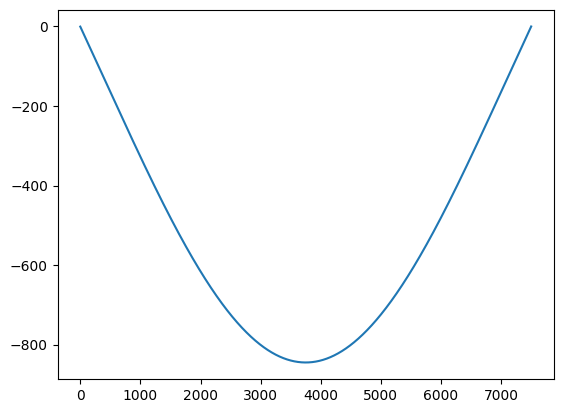

In [18]:
plt.plot(tonumpy(fittedwaveform))
len(fittedwaveform)

6500

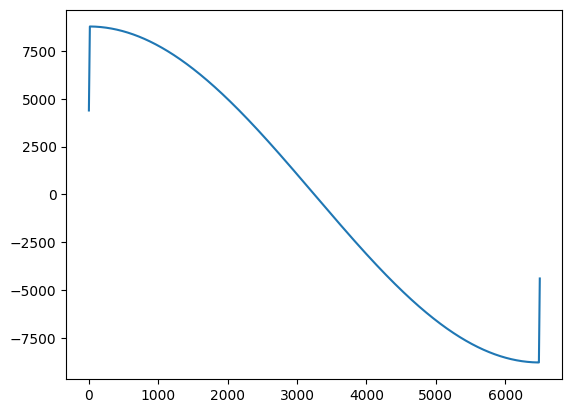

In [19]:
plt.plot(expanded_acceleration)
len(expanded_acceleration)

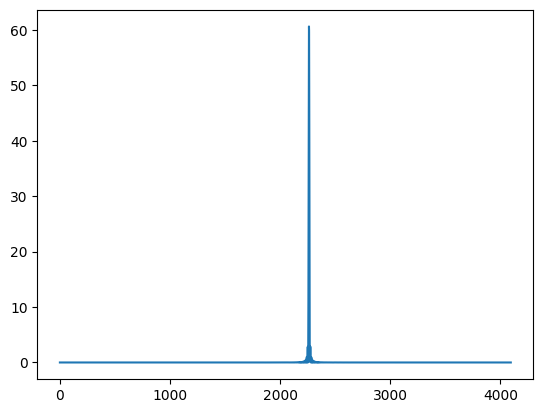

4.124815295656434
2262.3700684388073
10000
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0002
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0002
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.1348
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.1348
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
survivalprobability retrieved
0.0
waveform made
forces made
xout retrieved 10000
surviva

In [20]:
optimizedwaveform, optimizedLegendre, AWGwave_template = opt_atomsurvival_Legendre(fittedwaveform, fittedlegendre, 1e-6, globalvariables)
# optimizedwaveform, optimizedLegendre = opt_atomsurvival_PhaseOnly(AWGinitguess,500, 1e-6, globalvariables)

In [ ]:
def opt_forces_Legendre(fittedwaveform, desiredacceleration, fittedcoefficients, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = fittedwaveform.copy()
    AWGwave_template = tonumpy(fittedwaveform.copy())
    AWGwaveform_expresponse = exponentialphaseresponse(fittedwaveform)
    optimizationsection = AWGwaveform_expresponse[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(-1,1,len(optimizationsection))

    shotlast = realtofourier(zeropadframe(AWGwaveform_expresponse[-numpix_frame:], globalvariables))
    gaussianwidth = get_gaussianwidth_1d(tonumpy(zoomin((shotlast), 2)))
    
    def objective_survivalLegendre(params):
        legendre_poly = Legendre(params)
        reconstructed_waveform = legendre_poly(tonumpy(optimizationspace))
        AWGwave_template[numpix_frame:-numpix_frame] = reconstructed_waveform
        AWGwave_test = exponentialphaseresponse(tocupy(AWGwave_template))
        print("waveform made")
        forces = retrieveforces(AWGwave_test, globalvariables, 10, True)
        print("forces made")
        
        
        
        return 1 - survivalprobability

    initial_guess = fittedcoefficients
    
    # result = minimize(objective_survivalLegendre, tonumpy(initial_guess), method='Nelder-Mead', tol=1e-2,
    #     options={'maxfev ':1, 'maxiter':0, 'xtol':1e-2,'ftol':1e-2})

    result = minimize(objective_survivalLegendre,tonumpy(initial_guess),method='Powell',options={'disp': True,'maxfev':100,'maxiter':1, 'xtol': 1e-2, 'ftol': 1e-2})
    

    optimized_coefficients= result.x

    fitted_legendrepoly = Legendre(optimized_coefficients)
    AWGwaveform[numpix_frame:-numpix_frame] = tocupy(fitted_legendrepoly(tonumpy(optimizationspace)))
    
    return AWGwaveform, optimized_coefficients, AWGwave_template

In [ ]:
optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)

fittedwaveform, fittedlegendre = init_opt_waveformfitLegendre(AWGinitguess, 1000, globalvariables)

In [17]:
movetimes = np.arange(70,150,10)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

# movetimes = np.array([200])*10**(-6)
# movetemperatures = np.array([1])*10**(-6)


# ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "Linear", 1, globalvariables)
# notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "Linear", 1, globalvariables)
# idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 10, globalvariables)


1.922890580321072e-21
2155.203920338645
2.2493147708407158e-21
2155.2014233928767
2.652585743533475e-21
2155.1992828222524
2.812492856172391e-21
2155.1974316227966
2.8576372773459125e-21
2155.195858430982
2.9628432542848797e-21
2155.194502091825
3.987054106153568e-21
2155.193325699784
4.972552343690511e-21
2155.1922935089087


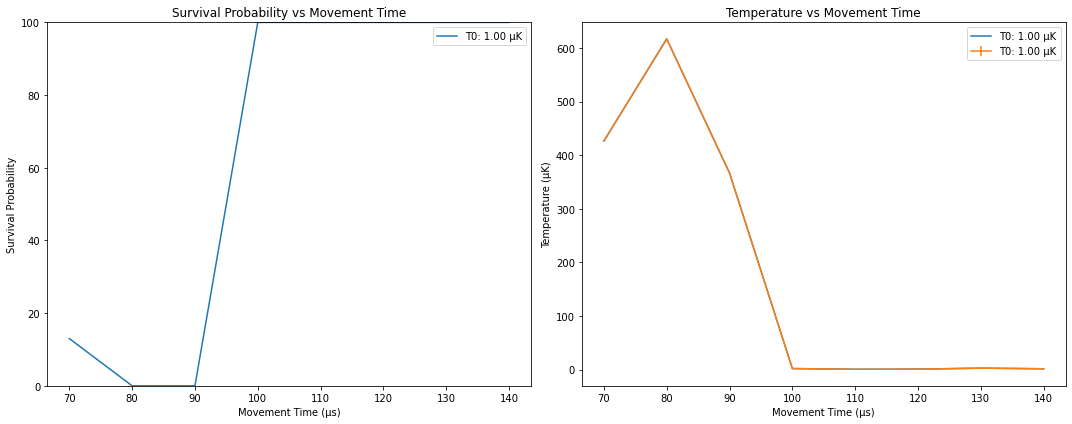

In [18]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

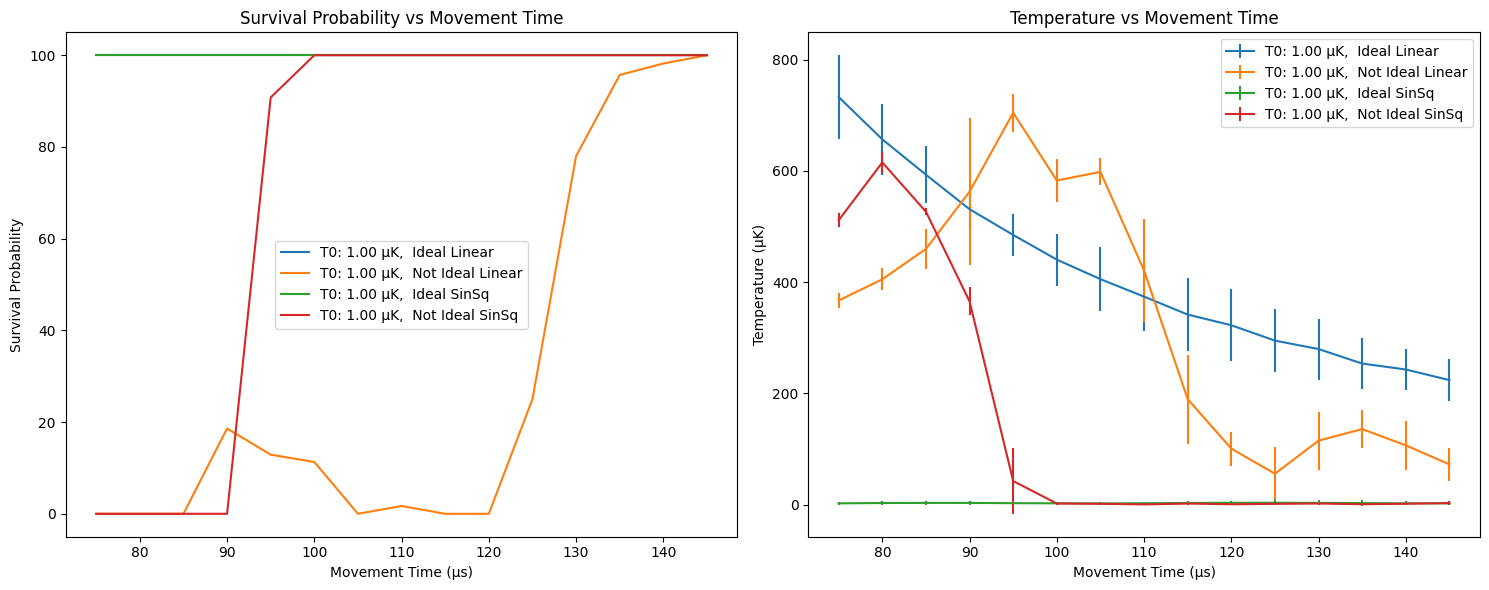

In [55]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([ideallinear, notideallinear, idealsinsq, notidealsinsq]), np.array(["Ideal Linear", "Not Ideal Linear", "Ideal SinSq", "Not Ideal SinSq"]))

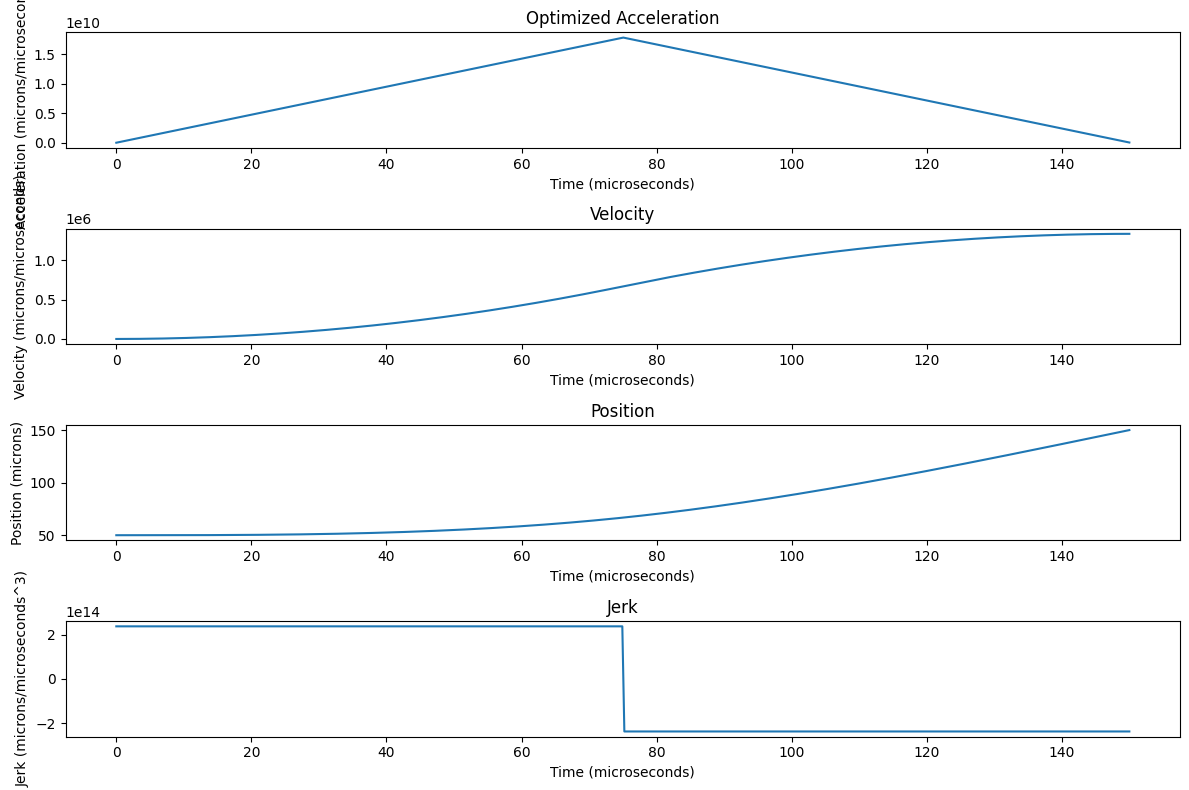

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()